## Naomi, Parshana, Sinchana, Joanna

In [484]:
%pip install pandas numpy matplotlib scikit-learn keras tensorflow nltk

Note: you may need to restart the kernel to use updated packages.


In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/naominayman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/naominayman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/naominayman/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## TASK 1 - EDA

### Question 1

In [486]:
df_main = pd.read_csv("S19_All_Release_2_10_22/Data/MainTable.csv")
df_subj = pd.read_csv("S19_All_Release_2_10_22/Data/LinkTables/Subject.csv")
df_problems = pd.read_csv("2nd CSEDM Data Challenge - Problem Prompts & Concepts Used - Sheet1.CSV")

In [487]:
# Number of unique students - using MainTable.csv
len(df_main['SubjectID'].unique())

413

In [488]:
# Number of unique students - using LinkTables/Subject.csv
len(df_subj['SubjectID'].unique())
# Less because some people did not take the final

372

### Question 2

In [489]:
df_early = pd.read_csv("S19_All_Release_2_10_22/early.csv")
df_late = pd.read_csv("S19_All_Release_2_10_22/late.csv")
df_all = pd.concat([df_early, df_late])

In [490]:
mean_attempts = df_all.groupby(['AssignmentID', 'ProblemID'])['Attempts'].mean()
mean_attempts.head()
print(f"Assignment {mean_attempts.idxmax()[0]} Problem {mean_attempts.idxmax()[1]} had the most attempts at {mean_attempts.max()}.")

Assignment 487.0 Problem 102 had the most attempts at 10.422535211267606.


### Question 3

In [491]:
df_main = pd.read_csv("S19_All_Release_2_10_22/Data/MainTable.csv")
df_compile = df_main[df_main['EventType'] == "Compile"]

In [492]:
compile_errors = df_compile[df_compile['Compile.Result'] == 'Error']
grouped_compile_errors = compile_errors.groupby(['AssignmentID', 'ProblemID'])['Compile.Result'].size()
print(f"Assignment {grouped_compile_errors.idxmax()[0]} Problem {grouped_compile_errors.idxmax()[1]} had the most compile errors at {grouped_compile_errors.max()}.")

Assignment 439.0 Problem 13 had the most compile errors at 2440.


Computing the total number of compiler errors faced on each problem, and report the maximum is more meaningful because it directly answers which problems had the most compile errors from all students. This is more meaningful for knowing which problems students as a whole struggled with compiling.

## Task 2 - Open-Ended Analysis

### Research Analysis 1: Analyzing frequency of errors changing over time

In [493]:
messages = df_main[df_main['EventType'] == "Compile.Error"][['ServerTimestamp','AssignmentID', 'ProblemID', 'CompileMessageData']]

messages['ServerTimestamp'] = pd.to_datetime(messages['ServerTimestamp'])
messages['Date'] = messages['ServerTimestamp'].dt.date

In [494]:
messages['CompileMessageData'] = messages['CompileMessageData'].apply(
    lambda x: re.sub(r"line \d+: (error: |\[empty\])?", "", x)
)
messages

,ServerTimestamp,AssignmentID,ProblemID,CompileMessageData,Date
14,2019-02-24 04:27:49,439.0,13,illegal start of expression.,2019-02-24
15,2019-02-24 04:27:49,439.0,13,illegal start of expression.,2019-02-24
16,2019-02-24 04:27:49,439.0,13,illegal start of expression.,2019-02-24
17,2019-02-24 04:27:49,439.0,13,illegal start of expression,2019-02-24
20,2019-02-24 04:29:44,439.0,13,missing return statement,2019-02-24
...,...,...,...,...,...
201541,2019-05-05 21:37:37,502.0,48,variable r is already defined in method withou...,2019-05-05
201542,2019-05-05 21:37:37,502.0,48,cannot find symbol: variable i,2019-05-05
201549,2019-05-05 23:26:16,502.0,56,cannot find symbol: variable min,2019-05-05
201556,2019-05-05 23:36:39,502.0,64,cannot find symbol: variable array,2019-05-05


CCategorize compile error messages into different types:

In [495]:
def categorize_error(msg):
    # Syntax Error
    if re.search(r"(illegal|cannot find symbol|character literal|illegal start of|illegal escape character|illegal character|unclosed string literal|illegal line end in character literal|invalid method declaration; return type required\.|array dimension missing|bad operand type int for unary operator '!'|bad initializer for for-loop|array required, but int found|no suitable constructor found for String\(char\)|not a statement|missing return statement|integer number too large)", msg, re.IGNORECASE):
        return "Syntax Error"
    # Type Error
    elif re.search(r"(bad operand type|dereferenced|type not allowed|unexpected type|char cannot be dereferenced|incompatible types|incomparable types|cannot be converted|bad operand types|int cannot be dereferenced|array dimension missing|incomparable types: boolean and int)", msg, re.IGNORECASE):
        return "Type Error"
    # Variable/Method not found
    elif re.search(r"(variable .+ is already defined|cannot assign a value to final variable|cannot assign a value to final variable this|cannot find symbol: method|cannot find symbol: variable|cannot find symbol: class)", msg, re.IGNORECASE):
        return "Variable/Method not found"
    # Initialization Issues
    elif re.search(r"(variable declaration not allowed here|variable .+ might not have been initialized|invalid method declaration|class expected|class .+ is already defined)", msg, re.IGNORECASE):
        return "Initialization Issues"
    # Control Flow
    elif re.search(r"(for-each not applicable to expression type|orphaned case|break outside switch or loop|unreachable statement|'else' without 'if'|reached end of file|empty statement after if|'finally' without 'try'|return outside method|while expected)", msg, re.IGNORECASE):
        return "Control Flow"
    # Class/Interface declaration
    elif re.search(r"(class, interface, or enum expected)", msg, re.IGNORECASE):
        return "Class/Interface declaration"
    # Method Argument Errors
    elif re.search(r"(required, but|missing method|method .+ already defined|method .+ cannot be applied to given types|no arguments|no suitable method found)", msg, re.IGNORECASE):
        return("Method Argument")
    # Character expected
    elif re.search(r"(: expected|';' expected|'\)' expected|'\]' expected|'\[' expected|'\(' expected|; expected|> expected|' expected)", msg, re.IGNORECASE):
        return("Char Expected")
    else:
        return "Other"
messages['ErrorCategory'] = messages['CompileMessageData'].apply(categorize_error)

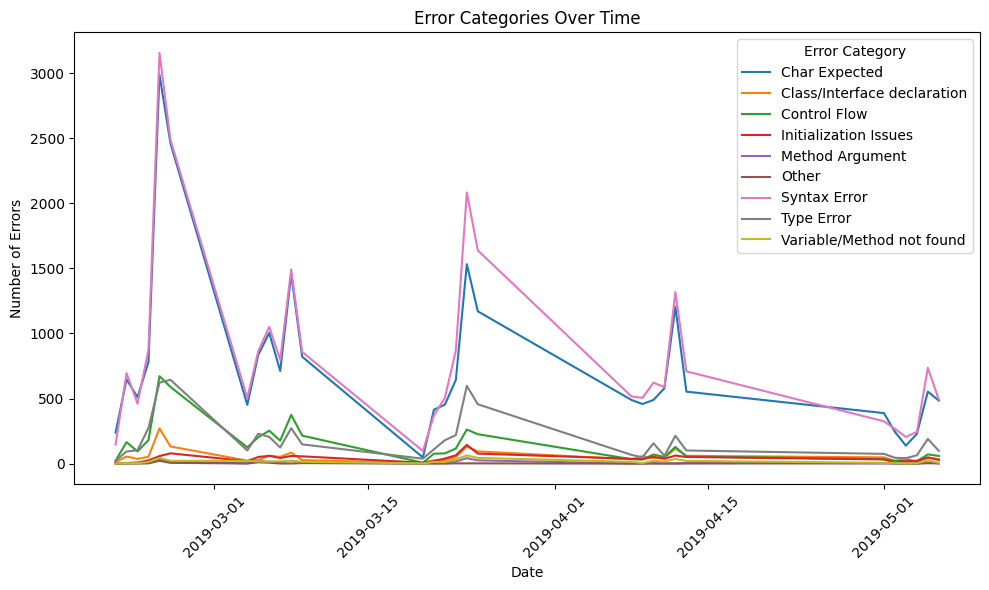

In [496]:
error_counts = messages.groupby(['Date', 'ErrorCategory']).size().unstack(fill_value=0)

# Plotting the line graph
plt.figure(figsize=(10, 6))
for category in error_counts.columns:
    plt.plot(error_counts.index, error_counts[category], label=category)

plt.xlabel('Date')
plt.ylabel('Number of Errors')
plt.title('Error Categories Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Error Category')
plt.tight_layout()
plt.show()

We see spikes in errors presumably when an assignment is due, and students are compiling their code more often before the due date. The syntax errors and char expected errors are significantly higher than other types of errors. This is expected since novice programmers likely haven’t written enough code to check syntax thoroughly before compiling. Even advanced programmers forget a semicolon every now and then. Char expected errors also go hand in hand with syntax errors and can be linked to the same cause. 

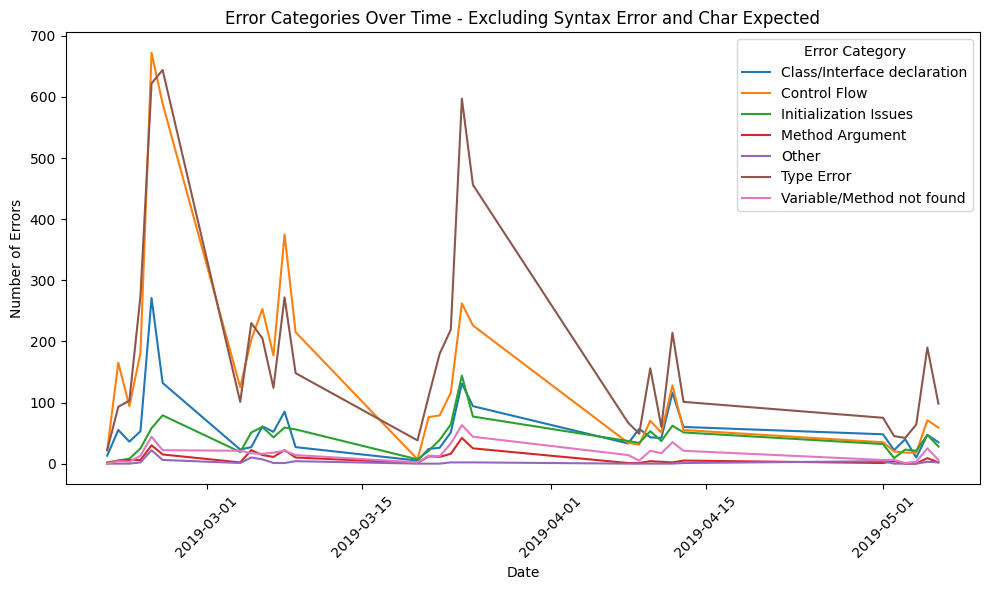

In [497]:
exclude_messages = messages[~messages['ErrorCategory'].isin(['Syntax Error', 'Char Expected'])]
error_counts_excluded = exclude_messages.groupby(['Date', 'ErrorCategory']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for category in error_counts_excluded.columns:
    plt.plot(error_counts_excluded.index, error_counts_excluded[category], label=category)

plt.xlabel('Date')
plt.ylabel('Number of Errors')
plt.title('Error Categories Over Time - Excluding Syntax Error and Char Expected')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Error Category')
plt.tight_layout()
plt.show()

This graph is the same as the one above, but without syntax and char expected errors, which were an overwhelming majority, clouding our analysis. We now see a new trend in control flow and type errors. However, only type errors spike halfway through the term in this graph. This can be compared with lecture material and lab assignments to find out which assignment in particular cause confusion among students. We can hypothesize that there might have been new types introduced that the students struggled with. All of the other types of errors are relatively low but they do not necessarily decrease as the term goes on. In fact, they get higher midway through, then drop low again. This leads us to believe that there was either a very challenging assignment halfway through the quarter, or some new concept was introduced that really altered the students’ understanding of concepts they excelled at before. 


### Research Analysis 2: Predicting Score from problem features

In [498]:
df_score = df_main[df_main['EventType'] == "Run.Program"]
df_score = df_score.groupby(['SubjectID', 'AssignmentID', 'ProblemID'])['Score'].max().reset_index()
score_problems = pd.merge(df_score, df_problems, on=['AssignmentID', 'ProblemID'], how='inner')
score_problems.head()

## collapse to one row per student by averaging the number of attempts per problem
df_grades = pd.merge(df_score, df_all, on=['SubjectID', 'AssignmentID', 'ProblemID'], how='inner')
df_grades = pd.merge(df_grades, df_subj, on=['SubjectID'], how='inner')
df_grades = pd.merge(df_grades, df_problems, on=['AssignmentID', 'ProblemID'], how='inner')

In [499]:
important_columns = ['SubjectID', 'AssignmentID', 'ProblemID', 'Attempts', 'Score', 'X-Grade','Requirement', 'If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction']

In [500]:
df_model = df_grades[important_columns]
# grab the highest scoring attempt for each student for each problem
df_max = df_model.loc[df_model.groupby(['SubjectID', 'AssignmentID', 'ProblemID'])['Score'].idxmax()]

In [501]:
## fill the problem details with the score if thay concept was present in the problem.
def replace_problem_details_with_score(df):
    problem_detail_cols = ['If/Else', 'NestedIf', 'While', 'For',
       'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr', 'LogicCompareNum',
       'LogicBoolean', 'StringFormat', 'StringConcat', 'StringIndex',
       'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex', 'DefFunction']

    for col in problem_detail_cols:
        df[col] = df.apply(lambda row: row['Score'] if row[col] == 1 else row[col], axis=1)
    
    return df

df_updated = replace_problem_details_with_score(df_max)

In [502]:
## get the average grade of the concept for each student
df_model = df_updated.groupby(['SubjectID', 'X-Grade'])[['If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction']].mean()

### Research Analysis 2 Part 2: Start building the model (s)

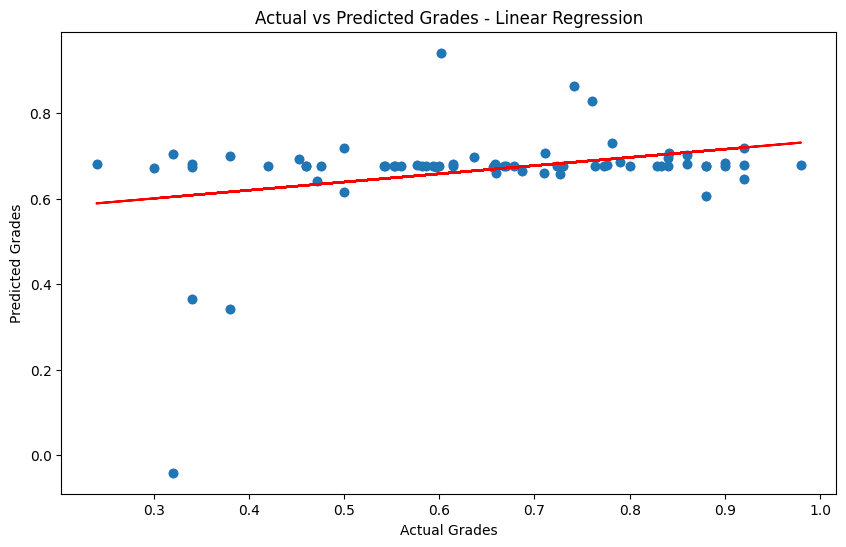

Root Mean Squared Error: 0.18225271774118884
R2: -0.003428354121903121


In [503]:
df_model = df_model.fillna(df_model.median())  # or df.fillna(df.median())

df_model.reset_index(inplace=True)

y = df_model['X-Grade']

X = df_model[['If/Else',
       'NestedIf', 'While', 'For', 'NestedFor', 'Math+-*/', 'Math%',
       'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean', 'StringFormat',
       'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual',
       'ArrayIndex', 'DefFunction']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


m, b = np.polyfit(y_test, y_pred, 1)
y_fit = m*y_test+b
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot(y_test, y_fit, color='red')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Actual vs Predicted Grades - Linear Regression')
plt.show()
RMSE = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2: {r2_score(y_test, y_pred)}')



Root Mean Squared Error: 0.1722016509410632
R2: 0.10419606865207842


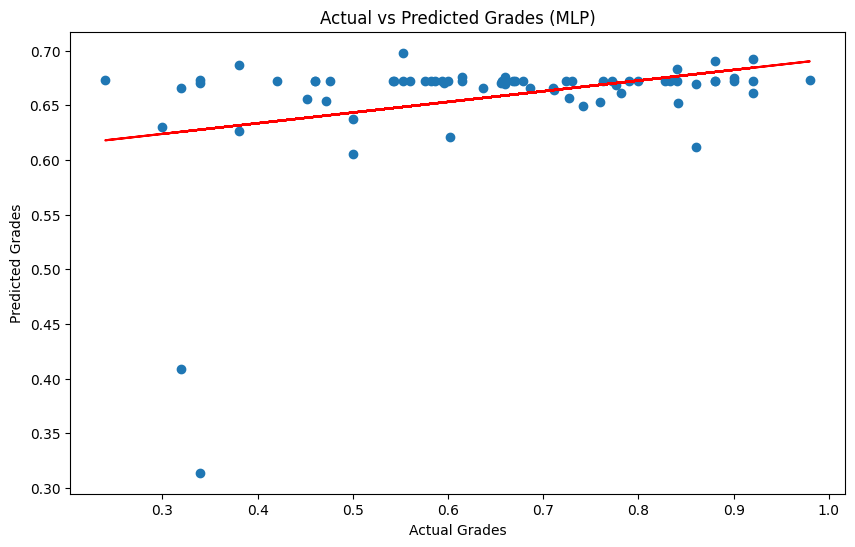

In [504]:
nn = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
m, b = np.polyfit(y_test, y_pred_nn, 1)
y_fit = m*y_test+b
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn)
plt.plot(y_test, y_fit, color='red')
plt.title('Actual vs Predicted Grades (MLP)')
plt.xlabel('Actual Grades') 
plt.ylabel('Predicted Grades')
RMSE = root_mean_squared_error(y_test, y_pred_nn)
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2: {r2_score(y_test, y_pred_nn)}')

Epoch 1/250


/Users/naominayman/Desktop/CalPoly/csc313/313-Data-Mining/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3419 - root_mean_squared_error: 0.5722 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2476
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0629 - root_mean_squared_error: 0.2492 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346 - root_mean_squared_error: 0.1858 - val_loss: 0.0321 - val_root_mean_squared_error: 0.1793
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364 - root_mean_squared_error: 0.1909 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1780
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353 - root_mean_squared_error: 0.1876 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1851
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0332 - root_mean_squared_error: 0.1822 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - root_mean_squar

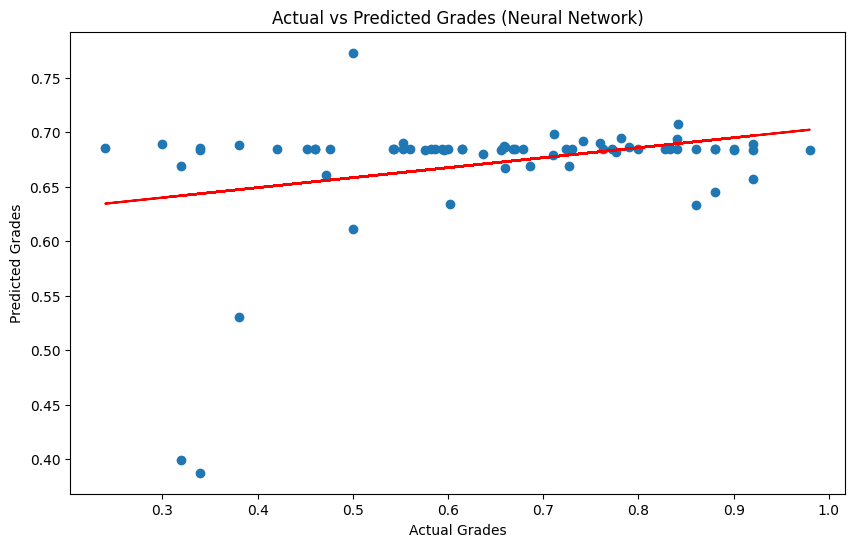

In [505]:
# Define the model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['root_mean_squared_error'])

history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.2, verbose=1)

y_pred_nn = model.predict(X_test)
m, b = np.polyfit(y_test, y_pred_nn, 1)
y_fit = m*y_test+b
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn)
plt.plot(y_test, y_fit, color='red')
plt.title('Actual vs Predicted Grades (Neural Network)')
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
RMSE = root_mean_squared_error(y_test, y_pred_nn)
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2: {r2_score(y_test, y_pred_nn)}')

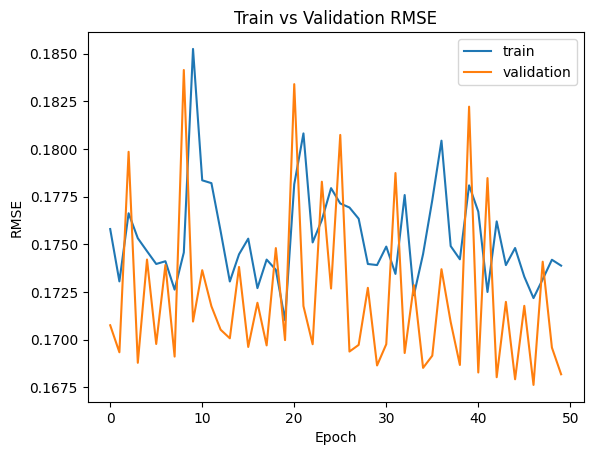

In [506]:
# plot train vs test RMSE
plt.plot(history.history['root_mean_squared_error'][200:], label='train')
plt.plot(history.history['val_root_mean_squared_error'][200:], label='validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.show()

### Research Analysis 2 Part 3: Attempting TFIDF

In [507]:
## find average score and attempts per problem
df_problem_avg = df_max.groupby(['AssignmentID','ProblemID', 'Requirement'])[['Score', 'Attempts']].mean().reset_index()

In [508]:
## problem wording preprocessing
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def custom_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemma.lemmatize(w.lower()) for w in tokens if w not in stop_words]
    return tokens

/Users/naominayman/Desktop/CalPoly/csc313/313-Data-Mining/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


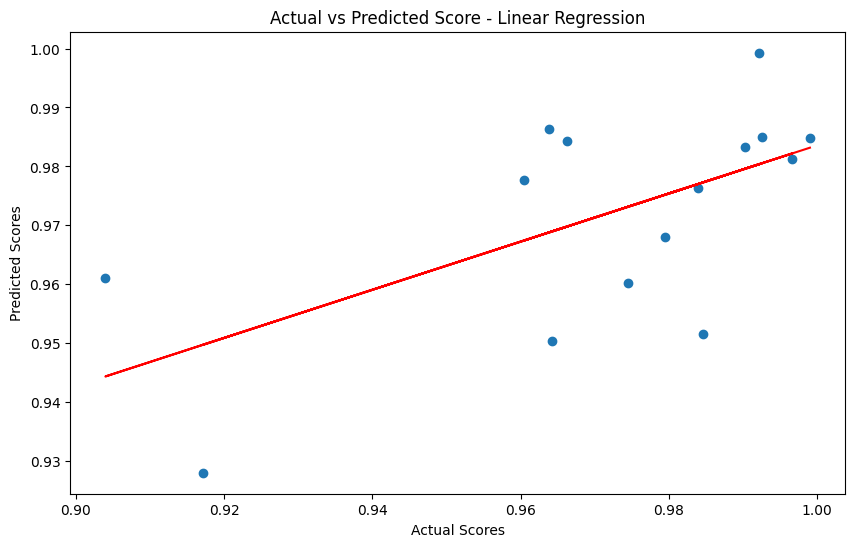

Root Mean Squared Error: 0.02126511142672743
R2: 0.3711822980008992


In [509]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
mms = MinMaxScaler()

X_text = vectorizer.fit_transform(df_problem_avg['Requirement']).toarray()

X_attempts = mms.fit_transform(df_problem_avg[['Attempts']]) ## scale average attempts to be on the same scale as the text features

X = np.hstack((X_text, X_attempts))

y = df_problem_avg['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
m, b = np.polyfit(y_test, y_pred, 1)
y_fit = m*y_test+b
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_fit, color='red')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Score - Linear Regression')
plt.show()
RMSE = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2: {r2_score(y_test, y_pred)}')

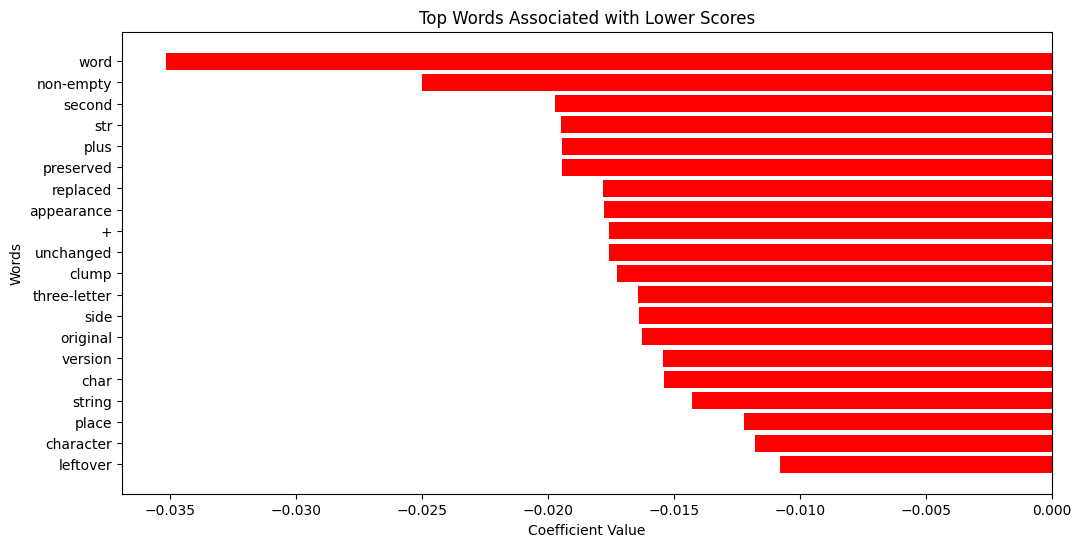

In [510]:
## Plot the most negatively impacting words
feature_names = vectorizer.get_feature_names_out()

coefficients = model.coef_[:-1]  # exclude the attempts coef

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance = feature_importance.sort_values(by='Coefficient') # sort by most negatively impacting words

top_negative_words = feature_importance.head(20)

plt.figure(figsize=(12, 6))
plt.barh(top_negative_words['Feature'], top_negative_words['Coefficient'], color='red')
plt.xlabel('Coefficient Value')
plt.ylabel('Words')
plt.title('Top Words Associated with Lower Scores')
plt.gca().invert_yaxis()
plt.show()

In [511]:
df_problem_avg[df_problem_avg['Requirement'].str.contains('word', case=False, na=False)]#['Requirement'].tolist()

,AssignmentID,ProblemID,Requirement,Score,Attempts
21,492.0,32,Write a function in Java that implements the f...,0.890000,6.603333
25,492.0,37,"Given two strings, return true if either of th...",0.984631,3.859813


In [512]:
df_problem_avg[df_problem_avg['Requirement'].str.contains('word', case=False, na=False)]['Requirement'].tolist()[0]

'Write a function in Java that implements the following logic: Given a string str and a non-empty word, return a version of the original string where all chars have been replaced by pluses (+), except for appearances of the word which are preserved unchanged.'

**This problem has the worst performance**

### Research Analysis 3: Investigating questions that had the highest number of variance and theorizing why students might have a high level of variance

In [513]:
df_early = pd.read_csv("S19_All_Release_2_10_22/early.csv")
df_late = pd.read_csv("S19_All_Release_2_10_22/late.csv")
df_subject = pd.read_csv("S19_All_Release_2_10_22/Data/LinkTables/Subject.csv")
df_all = pd.concat([df_early, df_late])
df = pd.merge(df_all, df_subject, left_on = 'SubjectID', right_on= 'SubjectID')
df

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label,X-Grade
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,False,0.7720
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,False,0.7720
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,False,0.7720
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,True,0.7720
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,False,0.7720
...,...,...,...,...,...,...,...
14873,ffb72475a81de0e95b910ffad039f5c2,502.0,64,2,True,True,0.6817
14874,ffb72475a81de0e95b910ffad039f5c2,502.0,70,2,True,True,0.6817
14875,ffb72475a81de0e95b910ffad039f5c2,502.0,71,1,True,True,0.6817
14876,ffb72475a81de0e95b910ffad039f5c2,502.0,112,1,True,True,0.6817


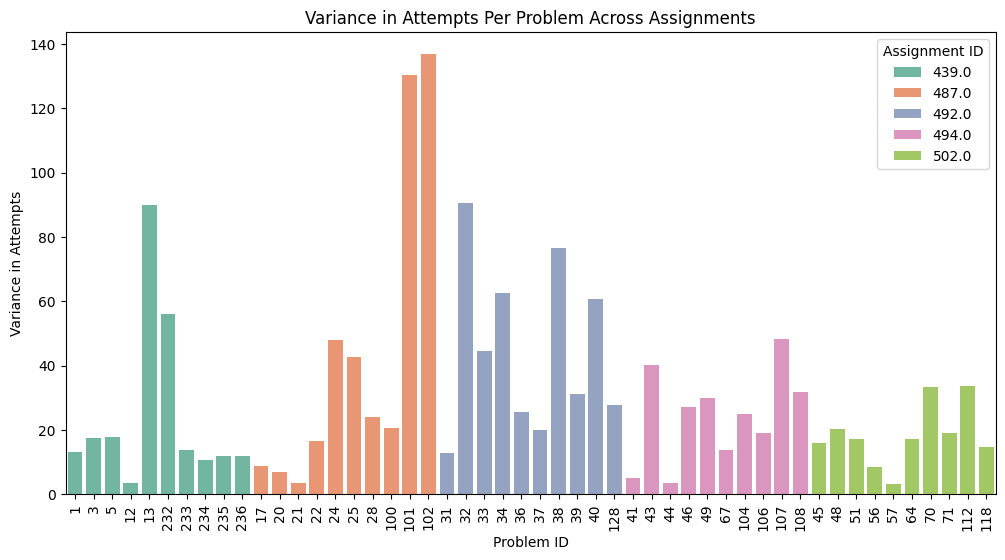

In [514]:
df = df.sort_values(by="AssignmentID")
attempt_variance = df.groupby(['AssignmentID', 'ProblemID'])['Attempts'].var().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='ProblemID', y='Attempts', hue='AssignmentID', data=attempt_variance, palette='Set2', order=attempt_variance.sort_values(['AssignmentID', 'ProblemID'])['ProblemID'])
plt.xlabel("Problem ID")
plt.ylabel("Variance in Attempts")
plt.title("Variance in Attempts Per Problem Across Assignments")
plt.xticks(rotation=90)
plt.legend(title="Assignment ID")
plt.show()
# Investigate problems 101, 102 as the varrying number of students from high to low amount of attempts to significantly bigger than others

This graph shows the variance in attempts for each question. Questions 101 and 102 had the highest variance by far, which means some students got it immediately, while other took several tries before they got the question correct. We can infer that these questions may have been about a concept that some students were not understanding clearly, or that there was an issue in the way the questions were worded. There was clearly a misunderstanding on the educator’s part either about the students’ understanding of the concept, or the clarity of the assignment. 

<Axes: xlabel='Attempts'>

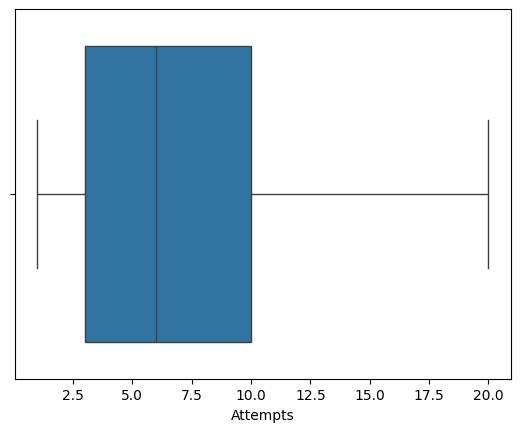

In [515]:
df_101 = df[(df['ProblemID'] == 101) & (df['AssignmentID'] == 487)]
sns.boxplot(x=df_101['Attempts'], showfliers=False)

Problem 101 Question: “We want to make a package of goal kilos of chocolate. We have small bars (1 kilo each) and big bars (5 kilos each). Return the number of small bars to use, assuming we always use big bars before small bars. Return -1 if it can't be done.”

This is a box plot of the attempts on question 101. It shows that 50% of students got between 1-6 attempts, 50% of students got between 6-20 attempts. These are wide quartiles and prompt us to look into what caused so much confusion. After reading the question, we can see that it was difficult to understand what was being asked of the students. The first sentence doesn’t give enough context for students to know what they are looking for, or returning, in the code. This is the first point of confusion. The questions continues on to explain what types of bars there are and the rules on how many of each to use. Students likely made assumptions about how many big bars to use, and what the big and small bars must add up to. After this analysis, it is more than likely that the question itself was worded in a way that made it difficult for students to understand. We can infer that most students got it correct after understanding what to do, but that is the part that caused so much variance in number of attempts. In the future, the educator should either clarify the question or not use it anymore. 

<Axes: xlabel='Attempts'>

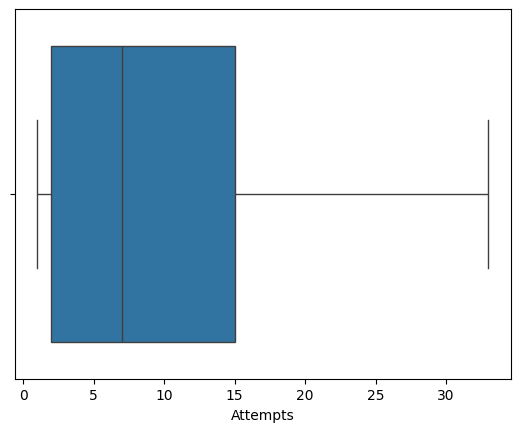

In [516]:
df_102 = df[(df['ProblemID'] == 102) & (df['AssignmentID'] == 487)]
sns.boxplot(x=df_102['Attempts'], showfliers=False)

Problem 102 Question: Given a string, if the same 2-character substring appears at both its beginning and end, return the contents of the string without the 2-character substring at the beginning. For example, "HelloHe" yields "lloHe". Note that the 2-character substring at the beginning may overlap with the one at the end, so "Hi" yields "". If the two characters at the start and end of the string do not match each other, return the original string unchanged.

Question 102 asks for string manipulation. 50% of students got between 1-7 attempts, 50% of students got between 8-38 attempts. While the question itself is relatively clear, it does seem like there would be some edge cases, one of which is clarified in the prompt. For example, case sensitivity is not clarified in the question, so some students may have changed all the letters to lowercase for matching purposes. Additionally, strings such at “aa” or “” will return empty strings which could also cause issues for novice programmers. Test cases could also include cases with strings of length 1, which would return the same string. However, if the program the student wrote does not check string length then it would throw an error. This question has some ambiguity on how certain cases are handled which we can assume is the cause for large variance in attempts. 
